In [48]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import SimpleRNN, LSTM, GRU
from keras.layers import Dropout

# Data preparation

In [2]:
data = pd.read_csv("TSLA.csv")

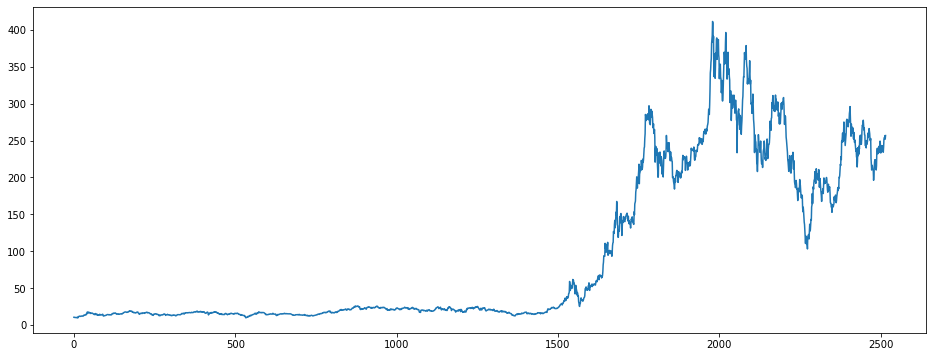

In [23]:
plt.figure(figsize=(16,6))
plt.plot(data.Open)

In [7]:
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2013-12-26,10.336000,10.533333,10.286000,10.366667,10.366667,106942500
1,2013-12-27,10.353333,10.366667,10.053333,10.074667,10.074667,81903000
2,2013-12-30,10.074667,10.320667,10.050000,10.162667,10.162667,67012500
3,2013-12-31,10.154667,10.213333,9.910667,10.028667,10.028667,63936000
4,2014-01-02,9.986667,10.165333,9.770000,10.006667,10.006667,92826000


In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2516 entries, 0 to 2515
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       2516 non-null   object 
 1   Open       2516 non-null   float64
 2   High       2516 non-null   float64
 3   Low        2516 non-null   float64
 4   Close      2516 non-null   float64
 5   Adj Close  2516 non-null   float64
 6   Volume     2516 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 137.7+ KB


## Splitting

In [28]:
length_data = len(data)     # rows that data has
split_ratio = 0.7           # %70 train + %30 validation
length_train = round(length_data * split_ratio)  
length_test = length_data - length_train
print("Data length :", length_data)
print("Train data length :", length_train)
print("Test data lenth :", length_test)

Data length : 2516
Train data length : 1761
Test data lenth : 755


In [4]:
train_data = data[:length_train]
train_data

,Date,Open,High,Low,Close,Adj Close,Volume
0,2013-12-26,10.336000,10.533333,10.286000,10.366667,10.366667,106942500
1,2013-12-27,10.353333,10.366667,10.053333,10.074667,10.074667,81903000
2,2013-12-30,10.074667,10.320667,10.050000,10.162667,10.162667,67012500
3,2013-12-31,10.154667,10.213333,9.910667,10.028667,10.028667,63936000
4,2014-01-02,9.986667,10.165333,9.770000,10.006667,10.006667,92826000
...,...,...,...,...,...,...,...
1756,2020-12-16,209.410004,210.833328,201.666672,207.589996,207.589996,126287400
1757,2020-12-17,209.396667,219.606674,206.500000,218.633331,218.633331,168810300
1758,2020-12-18,222.966660,231.666672,209.513336,231.666672,231.666672,666378600
1759,2020-12-21,222.080002,222.833328,215.356674,216.619995,216.619995,174135900


In [5]:
test_data = data[length_train:]
test_data

,Date,Open,High,Low,Close,Adj Close,Volume
1761,2020-12-23,210.733337,217.166672,207.523331,215.326660,215.326660,99519000
1762,2020-12-24,214.330002,222.029999,213.666672,220.589996,220.589996,68596800
1763,2020-12-28,224.836670,227.133331,220.266663,221.229996,221.229996,96835800
1764,2020-12-29,220.333328,223.300003,218.333328,221.996674,221.996674,68732400
1765,2020-12-30,224.000000,232.199997,222.786667,231.593338,231.593338,128538000
...,...,...,...,...,...,...,...
2511,2023-12-18,253.779999,258.739990,251.360001,252.080002,252.080002,116416500
2512,2023-12-19,253.479996,258.339996,253.009995,257.220001,257.220001,106737400
2513,2023-12-20,256.410004,259.839996,247.000000,247.139999,247.139999,125097000
2514,2023-12-21,251.899994,254.800003,248.550003,254.500000,254.500000,109594200


In [52]:
dataset_train = train_data.Open.values
dataset_train.shape

(1761,)

In [53]:
dataset_train = np.reshape(dataset_train, (-1,1))
dataset_train.shape

(1761, 1)

In [54]:
dataset_test = test_data.Open.values
dataset_test.shape

(755,)

In [55]:
dataset_test = np.reshape(dataset_test, (-1,1))
dataset_test.shape

(755, 1)

## Scaling


In [56]:
scaler1 = MinMaxScaler(feature_range = (0,1))
dataset_train_scaled = scaler1.fit_transform(dataset_train)

In [57]:
dataset_train_scaled

array([[0.00453808],
       [0.00461922],
       [0.00331461],
       ...,
       [1.        ],
       [0.99584898],
       [0.96738455]])

In [58]:
scaler2 = MinMaxScaler(feature_range = (0,1))
dataset_test_scaled = scaler2.fit_transform(dataset_test)

## Creating x and y train datasets

In [59]:
X_train = []
y_train = []

time_step = 50

for i in range(time_step, length_train):
    X_train.append(dataset_train_scaled[i-time_step:i,0])
    y_train.append(dataset_train_scaled[i,0])
    
X_train, y_train = np.array(X_train), np.array(y_train)

In [60]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
y_train = np.reshape(y_train, (y_train.shape[0], 1))

## Creating x and y test datasets

In [61]:
X_test = []
y_test = []

time_step = 50

for i in range(time_step, length_test):
    X_test.append(dataset_test_scaled[i-time_step:i,0])
    y_test.append(dataset_test_scaled[i,0])
    
X_test, y_test = np.array(X_test), np.array(y_test)

In [62]:
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
y_test = np.reshape(y_test, (y_test.shape[0], 1))

# RNN models

https://www.kaggle.com/code/ozkanozturk/stock-price-prediction-by-simple-rnn-and-lstm

## Simple RNN

In [78]:
model_simple = Sequential()

model_simple.add(SimpleRNN(units = 50, input_shape = (X_train.shape[1],1)))

model_simple.add(Dropout(0.2))

model_simple.add(Dense(units = 1))

model_simple.compile(
    optimizer = "adam", 
    loss = "mean_squared_error",
    metrics = ["accuracy"])

fitted = model_simple.fit(X_train, y_train, epochs = 50, batch_size = 32)

Epoch 1/50
54/54 [==============================] - 1s 8ms/step - loss: 0.0042 - accuracy: 5.8445e-04
Epoch 2/50
54/54 [==============================] - 0s 6ms/step - loss: 0.0017 - accuracy: 5.8445e-04
Epoch 3/50
54/54 [==============================] - 0s 5ms/step - loss: 0.0012 - accuracy: 5.8445e-04
Epoch 4/50
54/54 [==============================] - 0s 6ms/step - loss: 0.0010 - accuracy: 5.8445e-04
Epoch 5/50
54/54 [==============================] - 0s 6ms/step - loss: 9.1044e-04 - accuracy: 5.8445e-04
Epoch 6/50
54/54 [==============================] - 0s 6ms/step - loss: 8.3018e-04 - accuracy: 5.8445e-04
Epoch 7/50
54/54 [==============================] - 0s 5ms/step - loss: 7.2844e-04 - accuracy: 5.8445e-04
Epoch 8/50
54/54 [==============================] - 0s 5ms/step - loss: 7.8930e-04 - accuracy: 5.8445e-04
Epoch 9/50
54/54 [==============================] - 0s 6ms/step - loss: 7.8236e-04 - accuracy: 5.8445e-04
Epoch 10/50
54/54 [==============================] - 0s 6ms/st

Text(0, 0.5, 'Losses')

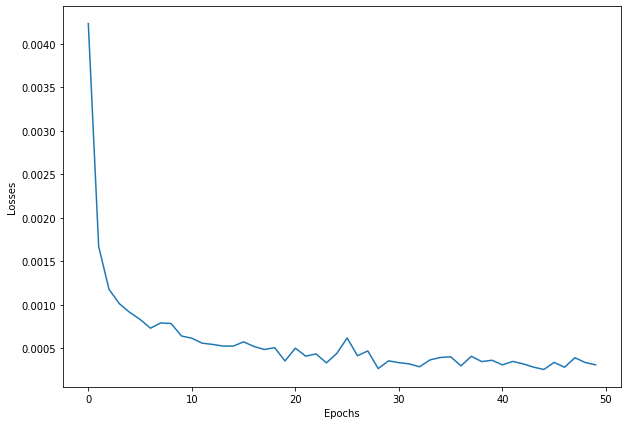

In [79]:
plt.figure(figsize =(10,7))
plt.plot(fitted.history["loss"])
plt.xlabel("Epochs")
plt.ylabel("Losses")

In [80]:
y_pred = model_simple.predict(X_train)  

54/54 [==============================] - 0s 3ms/step


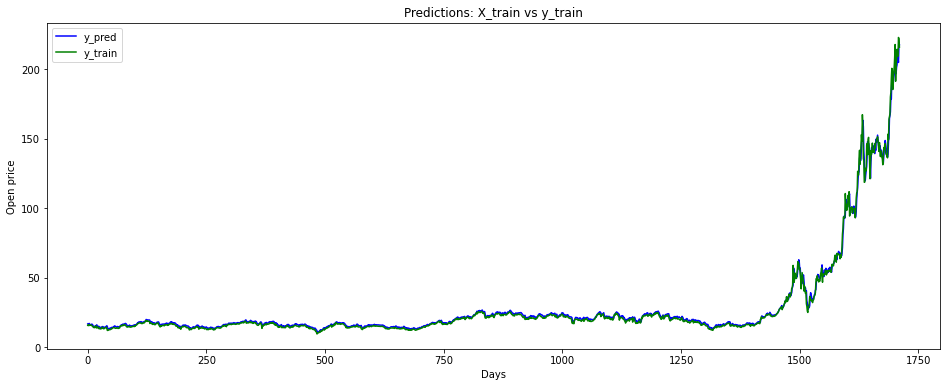

In [81]:
plt.figure(figsize = (16,6))
plt.plot(scaler1.inverse_transform(y_pred), color = "b", label = "y_pred" )
plt.plot(scaler1.inverse_transform(y_train), color = "g", label = "y_train")
plt.xlabel("Days")
plt.ylabel("Open price")
plt.title("Predictions: X_train vs y_train")
plt.legend()

In [82]:
y_pred_test = model_simple.predict(X_test)

23/23 [==============================] - 0s 3ms/step


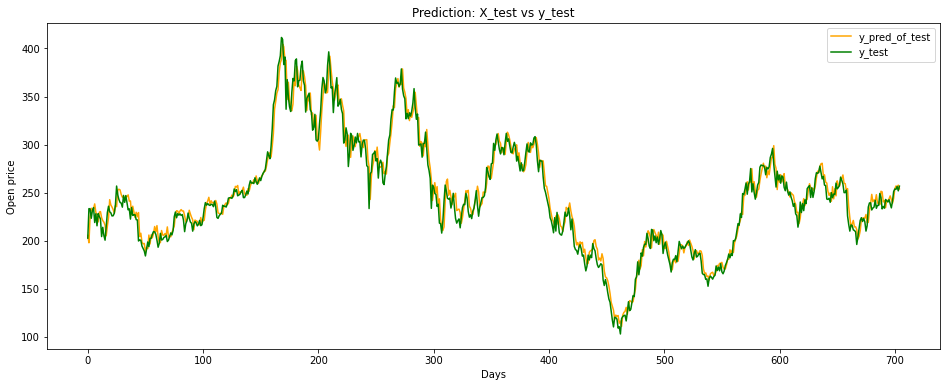

In [83]:
plt.figure(figsize = (16,6))
plt.plot(scaler2.inverse_transform(y_pred_test) , label = "y_pred_of_test", c = "orange")
plt.plot(scaler2.inverse_transform(y_test), label = "y_test", c = "g")
plt.xlabel("Days")
plt.ylabel("Open price")
plt.title("Prediction: X_test vs y_test")
plt.legend()

In [84]:
print('MSE: ', np.mean((scaler2.inverse_transform(y_pred_test) - scaler2.inverse_transform(y_test))**2))

MSE:  113.40780866920349


## LSTM

In [85]:
model_lstm = Sequential()

model_lstm.add(LSTM(units = 50, input_shape = (X_train.shape[1],1)))

model_lstm.add(Dropout(0.2))

model_lstm.add(Dense(units = 1))

model_lstm.compile(
    optimizer = "adam", 
    loss = "mean_squared_error",
    metrics = ["accuracy"])

fitted = model_lstm.fit(X_train, y_train, epochs = 50, batch_size = 32)

Epoch 1/50
54/54 [==============================] - 2s 14ms/step - loss: 0.0117 - accuracy: 0.0000e+00
Epoch 2/50
54/54 [==============================] - 1s 14ms/step - loss: 0.0014 - accuracy: 5.8445e-04
Epoch 3/50
54/54 [==============================] - 1s 14ms/step - loss: 8.5633e-04 - accuracy: 5.8445e-04
Epoch 4/50
54/54 [==============================] - 1s 14ms/step - loss: 8.9595e-04 - accuracy: 5.8445e-04
Epoch 5/50
54/54 [==============================] - 1s 14ms/step - loss: 7.8026e-04 - accuracy: 5.8445e-04
Epoch 6/50
54/54 [==============================] - 1s 15ms/step - loss: 9.1069e-04 - accuracy: 5.8445e-04
Epoch 7/50
54/54 [==============================] - 1s 13ms/step - loss: 6.2755e-04 - accuracy: 5.8445e-04
Epoch 8/50
54/54 [==============================] - 1s 14ms/step - loss: 5.8729e-04 - accuracy: 5.8445e-04
Epoch 9/50
54/54 [==============================] - 1s 13ms/step - loss: 6.3591e-04 - accuracy: 5.8445e-04
Epoch 10/50
54/54 [==========================

Text(0, 0.5, 'Losses')

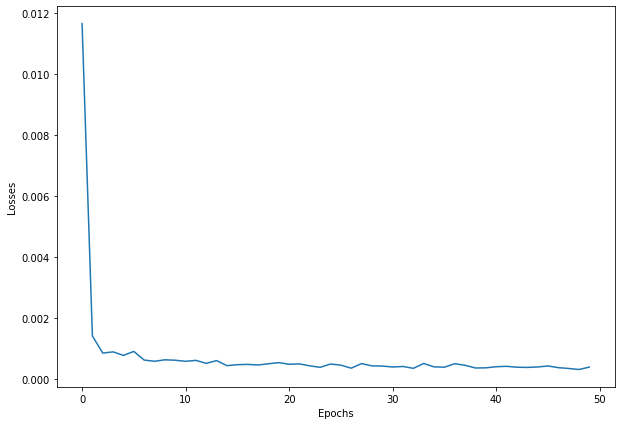

In [86]:
plt.figure(figsize =(10,7))
plt.plot(fitted.history["loss"])
plt.xlabel("Epochs")
plt.ylabel("Losses")

In [87]:
y_pred = model_lstm.predict(X_train)  

54/54 [==============================] - 1s 5ms/step


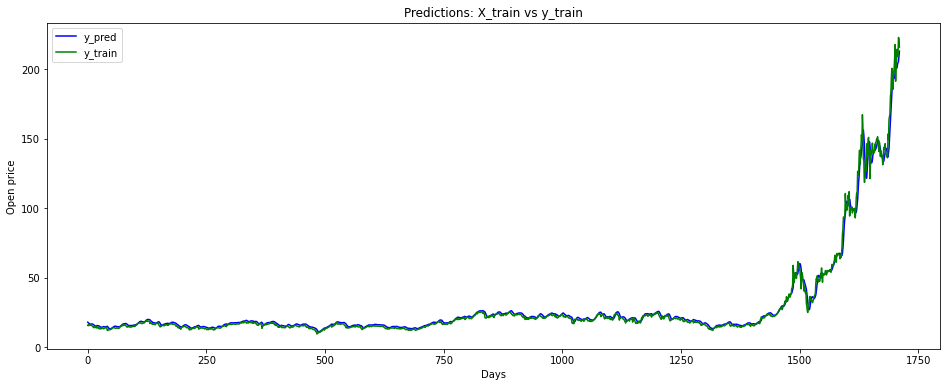

In [88]:
plt.figure(figsize = (16,6))
plt.plot(scaler1.inverse_transform(y_pred), color = "b", label = "y_pred" )
plt.plot(scaler1.inverse_transform(y_train), color = "g", label = "y_train")
plt.xlabel("Days")
plt.ylabel("Open price")
plt.title("Predictions: X_train vs y_train")
plt.legend()

In [89]:
y_pred_test = model_lstm.predict(X_test)

23/23 [==============================] - 0s 5ms/step


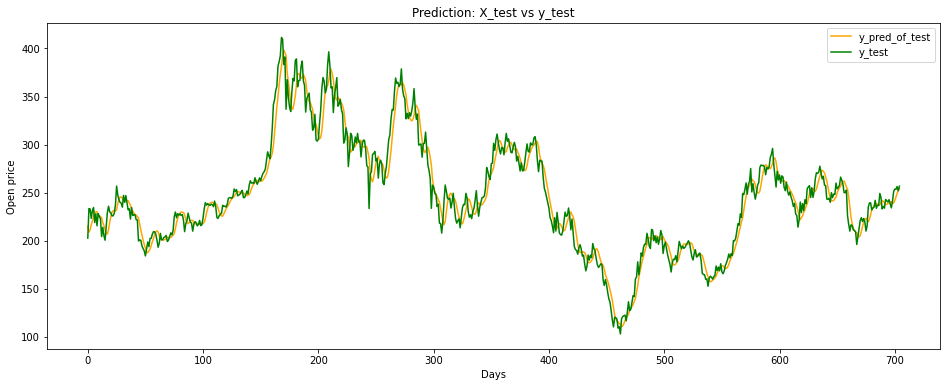

In [90]:
plt.figure(figsize = (16,6))
plt.plot(scaler2.inverse_transform(y_pred_test) , label = "y_pred_of_test", c = "orange")
plt.plot(scaler2.inverse_transform(y_test), label = "y_test", c = "g")
plt.xlabel("Days")
plt.ylabel("Open price")
plt.title("Prediction: X_test vs y_test")
plt.legend()

In [91]:
print('MSE: ', np.mean((scaler2.inverse_transform(y_pred_test) - scaler2.inverse_transform(y_test))**2))

MSE:  159.99027587078083


## GRU

In [93]:
model_gru = Sequential()

model_gru.add(GRU(units = 50, input_shape = (X_train.shape[1],1)))

model_gru.add(Dropout(0.2))

model_gru.add(Dense(units = 1))

model_gru.compile(
    optimizer = "adam", 
    loss = "mean_squared_error",
    metrics = ["accuracy"])

fitted = model_gru.fit(X_train, y_train, epochs = 50, batch_size = 32)

Epoch 1/50
54/54 [==============================] - 2s 15ms/step - loss: 0.0048 - accuracy: 5.8445e-04
Epoch 2/50
54/54 [==============================] - 1s 14ms/step - loss: 7.3647e-04 - accuracy: 5.8445e-04
Epoch 3/50
54/54 [==============================] - 1s 13ms/step - loss: 6.4901e-04 - accuracy: 5.8445e-04
Epoch 4/50
54/54 [==============================] - 1s 13ms/step - loss: 7.3755e-04 - accuracy: 5.8445e-04
Epoch 5/50
54/54 [==============================] - 1s 13ms/step - loss: 5.7014e-04 - accuracy: 5.8445e-04
Epoch 6/50
54/54 [==============================] - 1s 12ms/step - loss: 4.3034e-04 - accuracy: 5.8445e-04
Epoch 7/50
54/54 [==============================] - 1s 13ms/step - loss: 5.5705e-04 - accuracy: 5.8445e-04
Epoch 8/50
54/54 [==============================] - 1s 13ms/step - loss: 4.4721e-04 - accuracy: 5.8445e-04
Epoch 9/50
54/54 [==============================] - 1s 13ms/step - loss: 4.5486e-04 - accuracy: 5.8445e-04
Epoch 10/50
54/54 [======================

Text(0, 0.5, 'Losses')

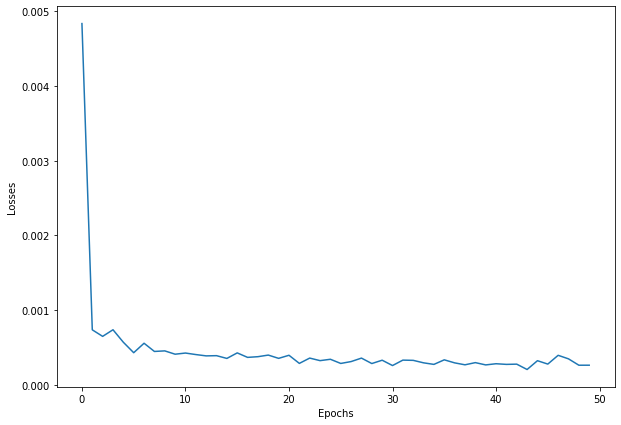

In [94]:
plt.figure(figsize =(10,7))
plt.plot(fitted.history["loss"])
plt.xlabel("Epochs")
plt.ylabel("Losses")

In [95]:
y_pred = model_lstm.predict(X_train)  

54/54 [==============================] - 0s 5ms/step


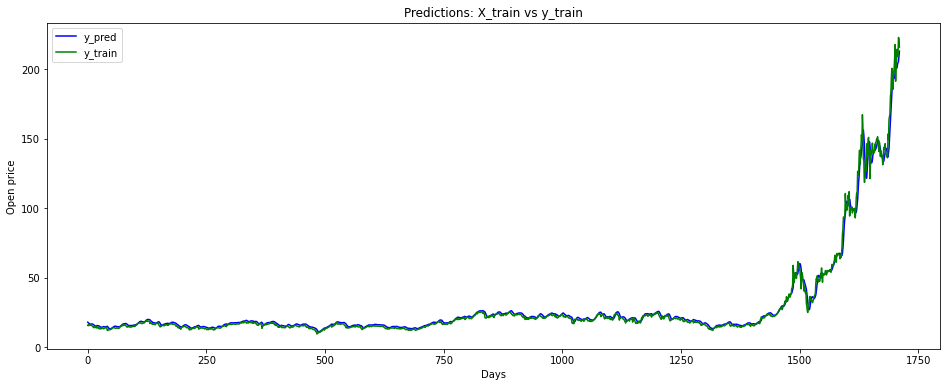

In [96]:
plt.figure(figsize = (16,6))
plt.plot(scaler1.inverse_transform(y_pred), color = "b", label = "y_pred" )
plt.plot(scaler1.inverse_transform(y_train), color = "g", label = "y_train")
plt.xlabel("Days")
plt.ylabel("Open price")
plt.title("Predictions: X_train vs y_train")
plt.legend()

In [101]:
y_pred_test = model_gru.predict(X_test)

23/23 [==============================] - 0s 6ms/step


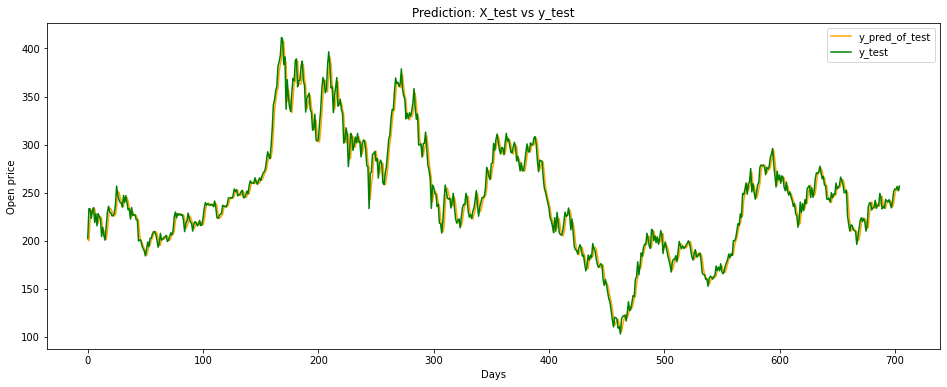

In [102]:
plt.figure(figsize = (16,6))
plt.plot(scaler2.inverse_transform(y_pred_test) , label = "y_pred_of_test", c = "orange")
plt.plot(scaler2.inverse_transform(y_test), label = "y_test", c = "g")
plt.xlabel("Days")
plt.ylabel("Open price")
plt.title("Prediction: X_test vs y_test")
plt.legend()

In [103]:
print('MSE: ', np.mean((scaler2.inverse_transform(y_pred_test) - scaler2.inverse_transform(y_test))**2))

MSE:  101.6063303867601


## GRU 2

In [106]:
model_gru = Sequential()

# adding first RNN layer and dropout regulatization
model_gru.add(GRU(units = 50, input_shape = (X_train.shape[1],1), return_sequences = True))

model_gru.add(Dropout(0.2))

model_gru.add(GRU(units = 50, return_sequences = True))

model_gru.add(Dropout(0.2))

model_gru.add(GRU(units = 50))

model_gru.add(Dropout(0.2))

model_gru.add(Dense(units = 1))

model_gru.compile(
    optimizer = "adam", 
    loss = "mean_squared_error",
    metrics = ["accuracy"])

fitted = model_gru.fit(X_train, y_train, epochs = 50, batch_size = 32)

Epoch 1/50
54/54 [==============================] - 6s 38ms/step - loss: 0.0038 - accuracy: 5.8445e-04
Epoch 2/50
54/54 [==============================] - 2s 38ms/step - loss: 9.3897e-04 - accuracy: 5.8445e-04
Epoch 3/50
54/54 [==============================] - 2s 38ms/step - loss: 6.9195e-04 - accuracy: 5.8445e-04
Epoch 4/50
54/54 [==============================] - 2s 39ms/step - loss: 9.2353e-04 - accuracy: 5.8445e-04
Epoch 5/50
54/54 [==============================] - 2s 38ms/step - loss: 8.3829e-04 - accuracy: 5.8445e-04
Epoch 6/50
54/54 [==============================] - 2s 38ms/step - loss: 9.0457e-04 - accuracy: 5.8445e-04
Epoch 7/50
54/54 [==============================] - 2s 38ms/step - loss: 6.5935e-04 - accuracy: 5.8445e-04
Epoch 8/50
54/54 [==============================] - 2s 39ms/step - loss: 6.4430e-04 - accuracy: 5.8445e-04
Epoch 9/50
54/54 [==============================] - 2s 39ms/step - loss: 6.7975e-04 - accuracy: 5.8445e-04
Epoch 10/50
54/54 [======================

Text(0, 0.5, 'Losses')

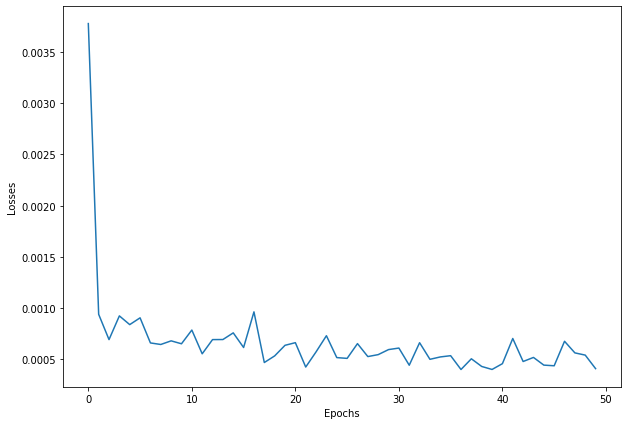

In [107]:
plt.figure(figsize =(10,7))
plt.plot(fitted.history["loss"])
plt.xlabel("Epochs")
plt.ylabel("Losses")

In [108]:
y_pred = model_lstm.predict(X_train)  

54/54 [==============================] - 0s 9ms/step


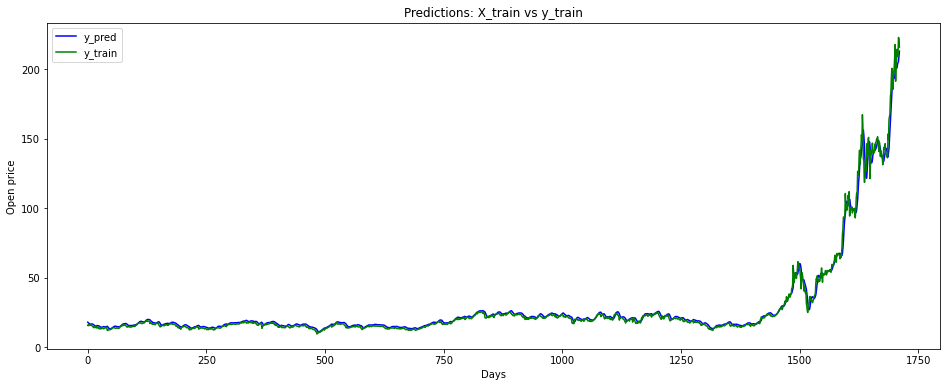

In [109]:
plt.figure(figsize = (16,6))
plt.plot(scaler1.inverse_transform(y_pred), color = "b", label = "y_pred" )
plt.plot(scaler1.inverse_transform(y_train), color = "g", label = "y_train")
plt.xlabel("Days")
plt.ylabel("Open price")
plt.title("Predictions: X_train vs y_train")
plt.legend()

In [110]:
y_pred_test = model_gru.predict(X_test)

23/23 [==============================] - 2s 21ms/step


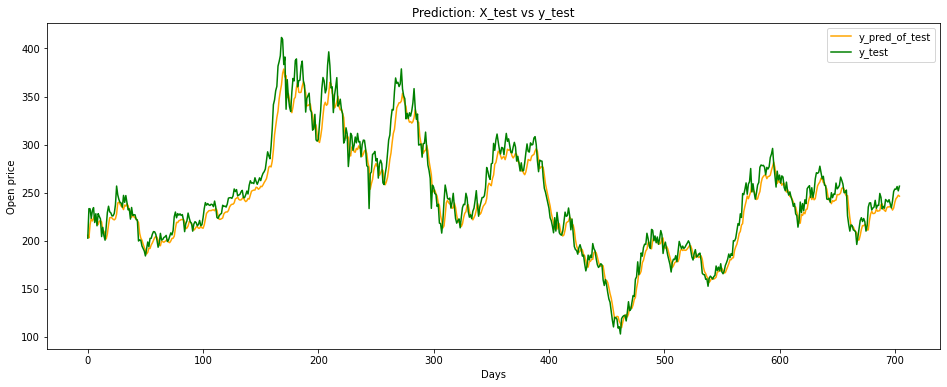

In [111]:
plt.figure(figsize = (16,6))
plt.plot(scaler2.inverse_transform(y_pred_test) , label = "y_pred_of_test", c = "orange")
plt.plot(scaler2.inverse_transform(y_test), label = "y_test", c = "g")
plt.xlabel("Days")
plt.ylabel("Open price")
plt.title("Prediction: X_test vs y_test")
plt.legend()

In [112]:
print('MSE: ', np.mean((scaler2.inverse_transform(y_pred_test) - scaler2.inverse_transform(y_test))**2))

MSE:  170.7590890751353
